# Response function comparison
*Developed by Stijn Klop and Mark Bakker*

The purpose of this notebook is to compare several of the response functions available in Pastas.
The Gamma and Hantush response function are compared with the Four Parameter function. 

### Gamma Step Response
The Gamma step response function is defined as:
$$ s(t) = A  \dfrac{1}{\Gamma(n)} \int_{0}^{t} \tau^{n-1} \cdot e^{-\tau/a} d\tau $$

### Hantush Step Response
The Hantush step response function is defined as:
$$ s(t) = A  \dfrac{1}{\int_{0}^{\infty} \tau^{-1} \cdot e^{-\tau/a - b/\tau} d\tau} \int_{0}^{t} \tau^{-1} \cdot e^{-\tau/a - b/\tau} d\tau $$

### FourParam Step Response
Both these response functions are compared with the Four Parameter response function. The Four Parameter response function is defined as:
$$ s(t) = A  \dfrac{1}{\int_{0}^{\infty} \tau^{n-1} \cdot e^{-\tau/a - b/\tau} d\tau} \int_{0}^{t} \tau^{n-1} \cdot e^{-\tau/a - b/\tau} d\tau $$

The Hantush and Gamma response function are special cases of the Four Parameter function. In this notebook these response functions are compared. This is done using syntheticly generated groundwater observations.

First the required packages are imported and the data is loaded. The rainfall and evaporation data are imported from KNMI station De Bilt using Pastas. An extraction time series is imported using the Pandas package. For this example the time series are selected from the year 1980 until 2000.

In [1]:
import numpy as np
from scipy.special import gammainc, gammaincinv
from scipy.integrate import quad
import pandas as pd
import pastas as ps
import matplotlib.pyplot as plt

%matplotlib inline

ps.show_versions()

Python version: 3.7.6 | packaged by conda-forge | (default, Jan  7 2020, 22:05:27) 
[Clang 9.0.1 ]
Numpy version: 1.17.5
Scipy version: 1.4.1
Pandas version: 0.25.0
Pastas version: 0.14.0b


In [2]:
rain = ps.read.read_knmi('data_notebook_5/etmgeg_260.txt', variables='RH').series
evap = ps.read.read_knmi('data_notebook_5/etmgeg_260.txt', variables='EV24').series
extraction = pd.read_csv('data_notebook_5/extraction.csv', 
                         index_col=0, parse_dates=True, dayfirst=True)['Extraction']

rain = rain['1980':'1999']
evap = evap['1980':'1999']
extraction = extraction['1980':'2000']

INFO: Inferred frequency from time series RH 260: freq=D 
INFO: Time Series RH 260: 30 nan-value(s) was/were found and filled with: 0.0
INFO: Inferred frequency from time series EV24 260: freq=D 


### Defining required functions
Several function are defined to generate the synthetic groundwater observations. In this example two groundwater series are generated, one using a Gamma response function and one using a Hantush response function. 




In [3]:
def gamma_tmax(A, n, a, cutoff=0.999):
    return gammaincinv(n, cutoff) * a

def gamma_step(A, n, a, cutoff=0.999):
    tmax = gamma_tmax(A, n, a, cutoff)
    t = np.arange(0, tmax, 1)
    s = A * gammainc(n, t / a)
    return s

def gamma_block(A, n, a, cutoff=0.999):
    # returns the gamma block response starting at t=0 with intervals of delt = 1
    s = gamma_step(A, n, a, cutoff)
    return np.append(s[0], s[1:] - s[:-1])

def hantush_func(t, a, b):
    return (t ** -1) * np.exp(-(a / t) - (t / b))

def hantush_step(A, a, b, tmax=1000, cutoff=0.999):
    t = np.arange(0, tmax)
    f = np.zeros(tmax)
    for i in range(1,tmax):
        f[i] = quad(hantush_func, i-1, i, args=(a, b))[0]
    F = np.cumsum(f)
    return (A / quad(hantush_func, 0, np.inf, args=(a, b))[0]) * F

def hantush_block(A, a, b, tmax=1000, cutoff=0.999):
    s = hantush_step(A, a, b, tmax=tmax, cutoff=cutoff)
    return s[1:] - s[:-1]

## Comparing the Gamma and the Four Parameter response function

The first test is to compare the Gamma with the Four Parameter response function. Using the function defined above the Gamma block response function can be generated. The parameters for the block response `Atrue`, `ntrue` and `atrue` are defined together with the `dtrue` parameter. A synthetic groundwater head series is generated using the block response function and the rainfall data series.


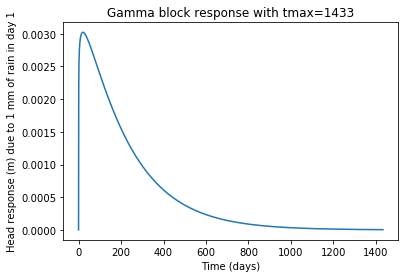

In [4]:
Atrue = 800
ntrue = 1.1
atrue = 200
dtrue = 20
h = gamma_block(Atrue, ntrue, atrue) * 0.001
tmax = gamma_tmax(Atrue, ntrue, atrue)
plt.plot(h)
plt.xlabel('Time (days)')
plt.ylabel('Head response (m) due to 1 mm of rain in day 1')
plt.title('Gamma block response with tmax=' + str(int(tmax)));

Text(0.5, 0, 'Time (years)')

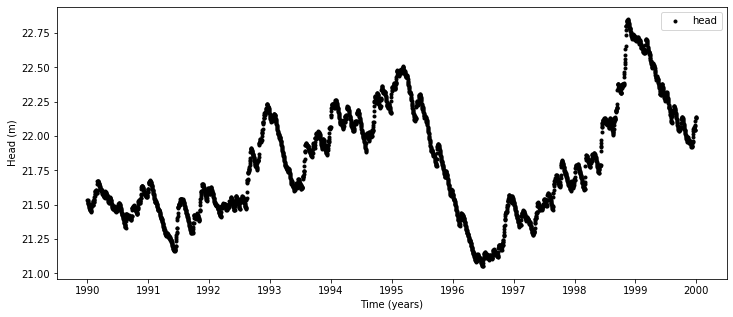

In [5]:
step = gamma_block(Atrue, ntrue, atrue)[1:]
lenstep = len(step)
h = dtrue * np.ones(len(rain) + lenstep)
for i in range(len(rain)):
    h[i:i + lenstep] += rain[i] * step
head = pd.DataFrame(index=rain.index, data=h[:len(rain)],)
head = head['1990':'1999']

plt.figure(figsize=(12,5))
plt.plot(head,'k.', label='head')
plt.legend(loc=0)
plt.ylabel('Head (m)')
plt.xlabel('Time (years)')

### Create Pastas model

The synthetic head series is used as input for the Pastas model. A stress model is created with the rainfall data series and the Gamma response function. The stress model is added to the Pastas model, and the model is solved.

INFO: Inferred frequency from time series 0: freq=D 
INFO: Inferred frequency from time series RH 260: freq=D 


Model Results 0                Fit Statistics
nfev     14                     EVP    100.00
nobs     3652                   R2       1.00
noise    False                  RMSE     0.00
tmin     1990-01-01 00:00:00    AIC       nan
tmax     1999-12-31 00:00:00    BIC       nan
freq     D                      ___          
warmup   3650 days 00:00:00     ___          
solver   LeastSquares           ___          

Parameters (4 were optimized)
            optimal  stderr     initial  vary
recharge_A    800.0  ±0.00%  224.669629  True
recharge_n      1.1  ±0.00%    1.000000  True
recharge_a    200.0  ±0.00%   10.000000  True
constant_d     20.0  ±0.00%   21.798909  True

Parameter correlations |rho| > 0.5
recharge_A recharge_a  0.68
           constant_d -0.99
recharge_n recharge_a -0.87
recharge_a constant_d -0.65


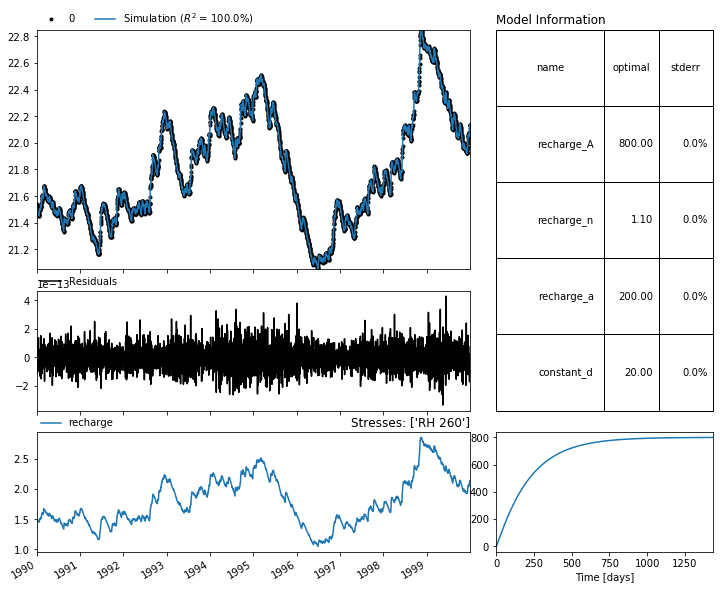

In [6]:
ml = ps.Model(head)
sm = ps.StressModel(rain, ps.Gamma, name='recharge', settings='prec')
ml.add_stressmodel(sm)
ml.solve(noise=False)
ml.plots.results()

The results of the Pastas simulation show that Pastas is able to simulate the synthetic groundwater head. The parameters calculated with Pastas are equal to the parameters used to generate the synthetic groundwater series; `Atrue`, `ntrue`, `atrue` and `dtrue`. 

### Create Pastas model using the Four Parameter response function
The next step is to simulate the synthetic head series using Pastas with the Four Parameter response function.
A new pastas model is created using the same head series as input. A stressmodel is created with the rainfall and the Four Parameter response function. The model is solved and the results are plotted.

INFO: Inferred frequency from time series 0: freq=D 
INFO: Inferred frequency from time series RH 260: freq=D 


Model Results 0                   Fit Statistics
nfev     16                     EVP       100.00
nobs     3652                   R2          1.00
noise    False                  RMSE        0.00
tmin     1990-01-01 00:00:00    AIC          nan
tmax     1999-12-31 00:00:00    BIC          nan
freq     D                      ___             
warmup   3650 days 00:00:00     ___             
solver   LeastSquares           ___             

Parameters (5 were optimized)
               optimal  stderr     initial  vary
recharge_A  800.486753  ±0.00%  224.669629  True
recharge_n    1.098166  ±0.00%    1.000000  True
recharge_a  200.604557  ±0.01%   10.000000  True
recharge_b    0.010000  ±2.17%   10.000000  True
constant_d   19.997166  ±0.00%   21.798909  True

Parameter correlations |rho| > 0.5
recharge_A recharge_a  0.68
           constant_d -0.99
recharge_n recharge_a -0.89
           recharge_b -0.58
recharge_a constant_d -0.66


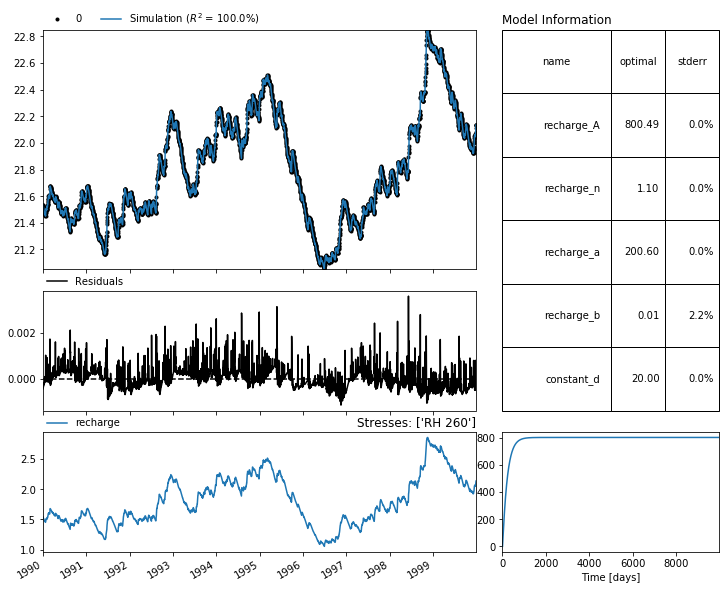

In [7]:
ml2 = ps.Model(head)
sm2 = ps.StressModel(rain, ps.FourParam, name='recharge', settings='prec')
ml2.add_stressmodel(sm2)
ml2.solve(noise=False)
ml2.plots.results()

The results of the Pastas simulation show that the groundwater head series can be simulated using the Four Parameter resposne function. The parameters calculated using Pastas only slightly deviate from the parameters `Atrue`, `ntrue`, `atrue` and `dtrue` defined above. The parameter `recharge_b` is almost equal to 0 (meaning that the Four Parameter responce function is almost equal to the Gamma response function, as can be seen above). 



## Comparing the Hantush and Four Parameter response function

In the second example of this notebook the Four Parameter response function is compared to the Hantush response function. A Hantush block response is plotted using the parameters; `Atrue_hantush`, `atrue_hantush`, `btrue_hantush`. The parameter `btrue_hantush` is calculated using `rho` and `atrue_hantush` according to Veling & Maas (2010).

The Hantush block response is used together with the extraction data series to simulate the synthetic groundwater head.

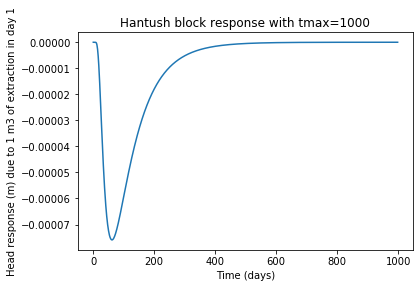

In [8]:
Atrue_hantush = -0.01 # Atrue is negative since a positive extraction results in a drop in groundwater head.
atrue_hantush = 100 # the parameter a is equal to cS in the hantush equation.
rho = 2
btrue_hantush = atrue_hantush * rho ** 2 / 4
dtrue_hantush = 20

h_hantush = hantush_block(Atrue_hantush, atrue_hantush, btrue_hantush) 
plt.plot(h_hantush)
plt.xlabel('Time (days)')
plt.ylabel('Head response (m) due to 1 m3 of extraction in day 1')
plt.title('Hantush block response with tmax=' + str(1000));

Text(0.5, 0, 'Time (years)')

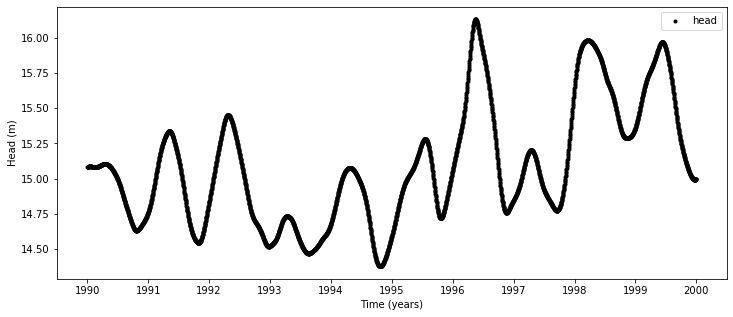

In [9]:
step_hantush = hantush_block(Atrue_hantush, atrue_hantush, btrue_hantush)[1:]
lenstep = len(step_hantush)
h_hantush = dtrue * np.ones(len(extraction) + lenstep)
for i in range(len(extraction)):
    h_hantush[i:i + lenstep] += extraction[i] * step_hantush
head_hantush = pd.DataFrame(index=extraction.index, data=h_hantush[:len(extraction)],)
head_hantush = head_hantush['1990':'1999']

plt.figure(figsize=(12,5))
plt.plot(head_hantush,'k.', label='head')
plt.legend(loc=0)
plt.ylabel('Head (m)')
plt.xlabel('Time (years)')

### Create Pastas model
A Pastas model is created using the `head_hantush` series as input. A stress model is created with the Pastas Hantush response function and the extraction as input. The stress model is added to the Pastas model and the Pastas model is solved. 

INFO: Inferred frequency from time series 0: freq=D 
INFO: Inferred frequency from time series Extraction: freq=D 


Model Results 0                      Fit Statistics
nfev     15                     EVP          100.00
nobs     3652                   R2             1.00
noise    False                  RMSE           0.00
tmin     1990-01-01 00:00:00    AIC             nan
tmax     1999-12-31 00:00:00    BIC             nan
freq     D                      ___                
warmup   3650 days 00:00:00     ___                
solver   LeastSquares           ___                

Parameters (4 were optimized)
                  optimal  stderr     initial  vary
extraction_A    -0.010005  ±0.01%   -0.015477  True
extraction_rho   1.991941  ±0.02%    1.000000  True
extraction_cS   99.454344  ±0.02%  100.000000  True
constant_d      20.000733  ±0.00%   15.084161  True

Parameter correlations |rho| > 0.5
extraction_A   extraction_rho  0.63
               extraction_cS  -0.68
               constant_d     -1.00
extraction_rho extraction_cS  -0.97
               constant_d     -0.62
extraction_cS  constant_d

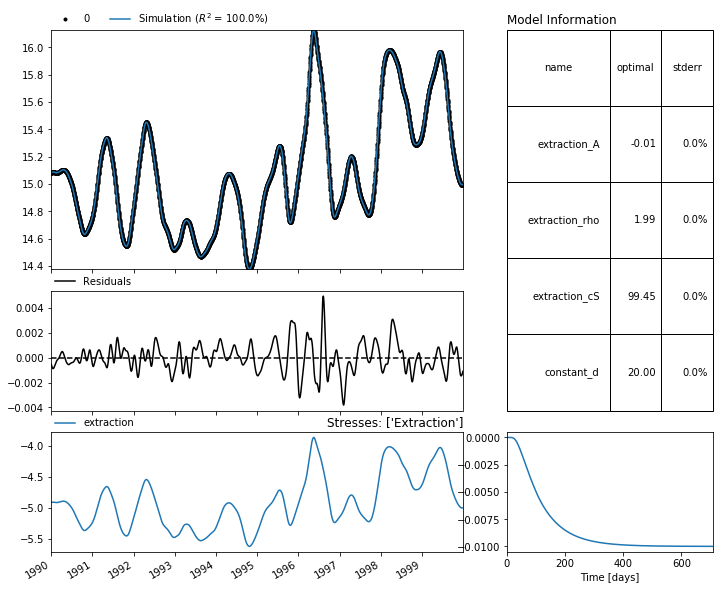

In [10]:
ml3 = ps.Model(head_hantush)
sm3 = ps.StressModel(extraction, ps.Hantush, name='extraction', settings='well', up=False)
ml3.add_stressmodel(sm3)
ml3.solve(noise=False)
ml3.plots.results()

The results of the Pastas simulation show that the observed head can be simulated using the Hantush response function. The parameters calibrated with Pastas are very close to the true parameters. 

### Create Pastas model using the Four Parameter response function
A new Pastas model is created. A stress model is created using the extraction data series and the Four Parameter function, `FourParam`, as input. The stress model is added to the Pastas model an the model is solved.

INFO: Inferred frequency from time series 0: freq=D 
INFO: Inferred frequency from time series Extraction: freq=D 


Model Results 0                   Fit Statistics
nfev     27                     EVP       100.00
nobs     3652                   R2          1.00
noise    False                  RMSE        0.00
tmin     1990-01-01 00:00:00    AIC          nan
tmax     1999-12-31 00:00:00    BIC          nan
freq     D                      ___             
warmup   3650 days 00:00:00     ___             
solver   LeastSquares           ___             

Parameters (5 were optimized)
                optimal  stderr    initial  vary
extraction_A  -0.009998  ±0.00%  -0.015477  True
extraction_n   0.086762  ±0.62%   1.000000  True
extraction_a  97.589819  ±0.02%  10.000000  True
extraction_b  92.873228  ±0.03%  10.000000  True
constant_d    19.999108  ±0.00%  15.084161  True

Parameter correlations |rho| > 0.5
extraction_A constant_d   -1.00
extraction_n extraction_a -0.99
             extraction_b -0.99
extraction_a extraction_b  0.95


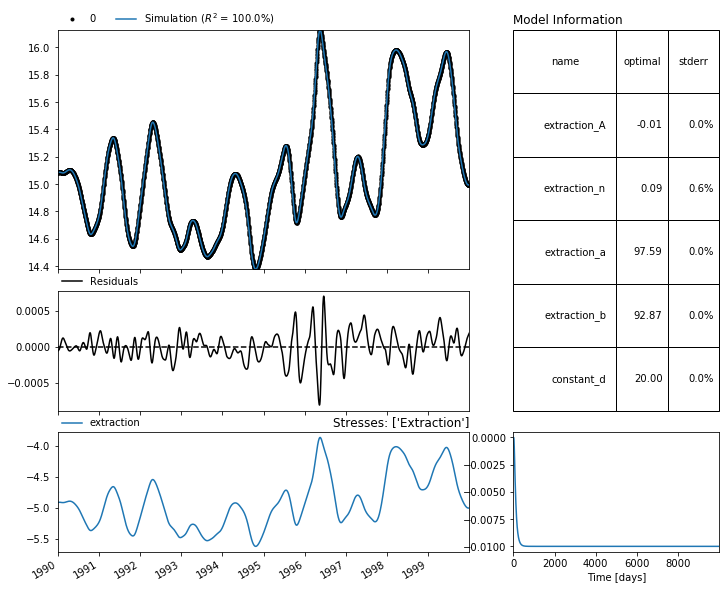

In [11]:
ml4 = ps.Model(head_hantush)
sm4 = ps.StressModel(extraction, ps.FourParam, name='extraction', settings='well', up=False)

ml4.add_stressmodel(sm4)
ml4.solve(noise=False)
ml4.plots.results()

The Pastas model is able to simulate the synthetic groundwater head. The parameters calibrated with Pastas with the Four Parameter function are close to the true parameters used to generate the groundwater head series. 

The deviations between the true and calibrated parameters are caused by the numerical aproximation of the Four Parameter response function used in Pastas. 

## References

- Hantush, M. S., & Jacob, C. E. (1955). Non‐steady radial flow in an
  infinite leaky aquifer. Eos, Transactions American Geophysical Union,
  36(1), 95-100.

- Veling, E. J. M., & Maas, C. (2010). Hantush well function
  revisited. Journal of hydrology, 393(3), 381-388.

- Von Asmuth, J. R., Maas, K., Bakker, M., & Petersen, J. (2008).
  Modeling time series of ground water head fluctuations subjected to
  multiple stresses. Ground Water, 46(1), 30-40.